# Тестирование kNN и SVD подходов в коллаборативной фильтрации

Нужно самостоятельно реализовать **коллаборативную фильтрацию** методами:
1. kNN нужно реализовать 2 базовых метода: <br>
    1.1. Простой kNN (в библиотеке `surprise` называется `KNNBasic`) <br>
    1.2. Непараметрическая регрессия Надарайя-Ватсона (в библиотеке `surprise` называется `KNNWithMeans`) <br>
2. SVD-разложение: <br>
    2.1. Метод SGD <br>
    2.2. Метод ALS <br>
3. SVD++


С полученными методами нужно произвести следующие исследования:
- Нужно сравнить время работы всех реализованных алгоритмов. 
- Нужно сравнить точность (в смысле RMSE) всех реализованных алгоритмов.
- Качество (в смысле RMSE) kNN по параметру k
- Качество (в смысле RMSE) SVD по числу факторов
- Качество (в смысле RMSE) SVD по числу итераций в SGD

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

### Данные

Для тестирования будем использовать датасет **MovieLens 100K Dataset**:<br>
MovieLens 100K movie ratings. Stable benchmark dataset. 100,000 ratings from 1000 users on 1700 movies. Released 4/1998. 
https://grouplens.org/datasets/movielens/100k/

In [104]:
dataset_dir = 'ml-100k'
dataset_filename = 'u.data'
dataset_path = os.path.join(dataset_dir, dataset_filename)
df = pd.read_csv(dataset_path, sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
df = df[['userId', 'movieId', 'rating']]

In [106]:
df.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [256]:
train, test = train_test_split(df, train_size=0.7, shuffle=True, random_state=41)
len(train), len(test)

(70000, 30000)

### KNN

In [311]:
from recsys.algo import knn
from recsys.utils import evaluate

In [269]:
algo_dict = {'KNNBasic': knn.KNNBasic(), 'KNNWithMeans': knn.KNNWithMeans()}
user_based_list = [True, False]
similarity_list = ['cosine', 'pearson']
k_neighbors_list = [1, 3, 5] + list(range(10, 110, 10))

In [272]:
res_list = list()

for algo_name, algo in algo_dict.items():
    for user_based in user_based_list:
        for similarity in similarity_list:
            time_start = time.time()
            algo.train(train,
                       rating_scale=(1, 5),
                       user_based=user_based,
                       similarity=similarity)
            train_time = time.time() - time_start
            for k_neighbors in tqdm.tqdm(k_neighbors_list):
                time_start = time.time()
                predictions = algo.test(test, k_neighbors=k_neighbors)
                test_time = time.time() - time_start
                res = {
                    'algo': algo_name,
                    'user_based': int(user_based),
                    'similarity': similarity,
                    'k_neighbors': k_neighbors,
                    'train_time': train_time,
                    'test_time': test_time
                }                
                score = evaluate(test['rating'], predictions)
                res.update(score)
                res_list.append(res)

100%|██████████████████████████████████████████| 13/13 [01:32<00:00,  7.08s/it]


In [273]:
df = pd.DataFrame(res_list)

In [318]:
df['total_time'] = df['train_time'] + df['test_time']

In [319]:
df.head()

,algo,user_based,similarity,k_neighbors,train_time,test_time,rmse,mae,total_time
0,KNNBasic,1,cosine,1,4.454255,6.266358,1.345325,1.002023,10.720613
1,KNNBasic,1,cosine,3,4.454255,6.238357,1.117915,0.880703,10.692611
2,KNNBasic,1,cosine,5,4.454255,6.159352,1.067006,0.846065,10.613607
3,KNNBasic,1,cosine,10,4.454255,6.161352,1.031239,0.821108,10.615607
4,KNNBasic,1,cosine,20,4.454255,6.177354,1.015701,0.808753,10.631608


In [320]:
groups = df.groupby(['algo', 'user_based', 'similarity'])

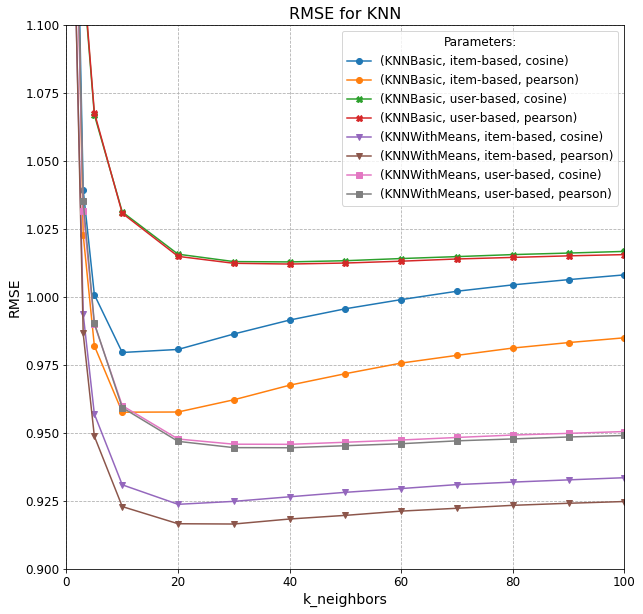

In [329]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
markers = {('KNNBasic', 0): 'o',
           ('KNNBasic', 1): 'X',
           ('KNNWithMeans', 0): 'v',
           ('KNNWithMeans', 1): 's',
          }

for group in groups:
    group_data = list(group[0])
    group_data[1] = 'user-based' if group_data[1] == 1 else 'item-based'
    line_label = '(' + ', '.join(group_data) + ')'
    marker = markers[(group[0][0], group[0][1])]
    group[1].plot(x='k_neighbors', y='rmse', label=line_label, ax=ax, marker=marker)
    
ax.set_title('RMSE for KNN', fontsize=16)
ax.set_xlabel('k_neighbors', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.legend(fontsize=14)
ax.grid(linestyle="--")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim(0, 100)
ax.set_ylim(0.9, 1.1)
ax.legend(title='Parameters:', title_fontsize=12, fontsize=12, loc="upper right");

Сравнение качества:

- качество `KNNWithMeans` ощутимо выше качества `KNNBasic` при любых значениях прочих параметров
- на данном датасете `item-based` подход работает лучше, чем `user-based`, что скорее всего связано с тем, что item'ов в данном датасете существенно больше, чем user'ов (1000 users vs 1700 movies)
- мера близости `pearson` (корреляция Пирсона) даёт более высокое качество, чем мера близости `cosine` (косинусная)
- для всех наборов параметров справедливо, что при увеличении количества соседей `k_neighbors` ошибка сначала падает, а потом, начиная с некоторого минимального значения, возрастает, что согласуется с интуицией

Таким образом, оптимальный набор параметров следующий:

In [322]:
df.iloc[df['rmse'].idxmin()]

algo           KNNWithMeans
user_based                0
similarity          pearson
k_neighbors              30
train_time        17.027974
test_time          7.027402
rmse               0.916424
mae                0.716432
total_time        24.055376
Name: 96, dtype: object

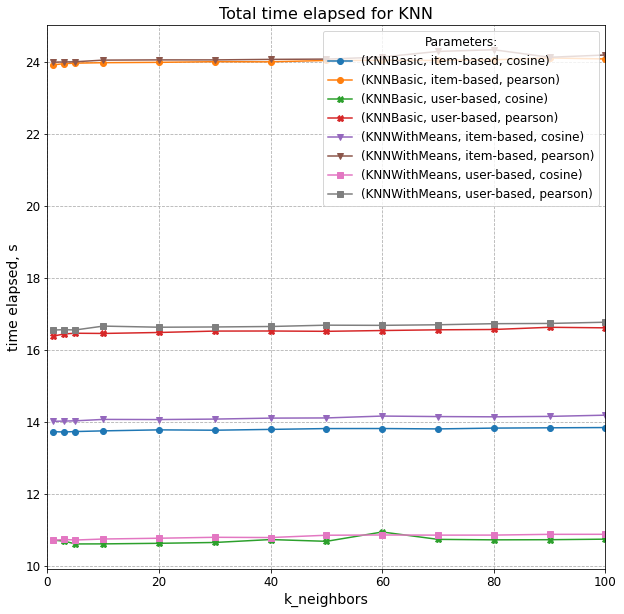

In [328]:
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
markers = {('KNNBasic', 0): 'o',
           ('KNNBasic', 1): 'X',
           ('KNNWithMeans', 0): 'v',
           ('KNNWithMeans', 1): 's',
          }

for group in groups:
    group_data = list(group[0])
    group_data[1] = 'user-based' if group_data[1] == 1 else 'item-based'
    line_label = '(' + ', '.join(group_data) + ')'
    marker = markers[(group[0][0], group[0][1])]
    group[1].plot(x='k_neighbors', y='total_time', label=line_label, ax=ax, marker=marker)
    
ax.set_title('Total time elapsed for KNN', fontsize=16)
ax.set_xlabel('k_neighbors', fontsize=14)
ax.set_ylabel('time elapsed, s', fontsize=14)
ax.legend(fontsize=14)
ax.grid(linestyle="--")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim(0, 100)
# ax.set_ylim(0.9, 1.1)
ax.legend(title='Parameters:', title_fontsize=12, fontsize=12, loc="upper right");

Сравнение времени работы:

- `KNNWithMeans` работает несущественно дольше `KNNBasic` при любых значениях прочих параметров
- `item-based` подход работает на 30...50 % дольше, чем `user-based`, что связано с тем, что item'ов в данном датасете в 1.7 раз больше, чем user'ов (1000 users vs 1700 movies)
- при использовании меры близости `pearson` (корреляция Пирсона) время работы возрастает примерно в 1.7 раз по сравнению с использованием меры близости `cosine` (косинусная); это объясняется тем, что при вычислении корреляции Пирсона мы вызываем функцию вычисления косинусной меры близости и еще проводим дополнительные вычисления
- для всех наборов параметров справедливо, что при увеличении количества соседей `k_neighbors` время работы медленно возрастает (медленно, потому что использован достаточно эффективный способ отбора ближайших соседей)

### SVD

In [367]:
from recsys.algo import svd

In [386]:
algo_dict = {'SVD_sgd': svd.SVD(method='sgd', biased=False),
             'SVD_sgd_biased': svd.SVD(method='sgd', biased=True),
             'SVD_als': svd.SVD(method='als')}
n_factors_list = [10, 20, 30, 40]
n_epochs = 30

In [387]:
res_list = list()

for algo_name, algo in algo_dict.items():
    for n_factors in n_factors_list:
        time_start = time.time()
        train_res_list = algo.train(train,
                                    val_dataset=test,
                                    n_epochs=n_epochs,
                                    n_factors=n_factors,
                                    verbose=False,
                                    check_durations=True,
                                    progress_bar=True
                                   )
        total_time = time.time() - time_start
        params = {
            'algo': algo_name,
            'n_factors': n_factors,
        }
        for d in train_res_list:
            d.update(params)
        res_list.extend(train_res_list)

100%|██████████████████████████████████████████| 30/30 [03:20<00:00,  6.67s/it]


In [388]:
df2 = pd.DataFrame(res_list)

In [389]:
df2.head()

,epoch,rmse_train,mae_train,rmse_val,mae_val,epoch_time_elapsed,eval_time_elapsed,algo,n_factors
0,1,3.696979,3.522281,3.705509,3.528838,3.238185,0.990057,SVD_sgd,10
1,2,3.450693,3.273287,3.465914,3.286399,3.239185,0.992057,SVD_sgd,10
2,3,1.993196,1.636305,2.023523,1.662736,3.221184,0.990057,SVD_sgd,10
3,4,1.421082,1.102004,1.463615,1.131935,3.227185,0.997057,SVD_sgd,10
4,5,1.196001,0.921672,1.243143,0.953130,3.230185,0.991056,SVD_sgd,10


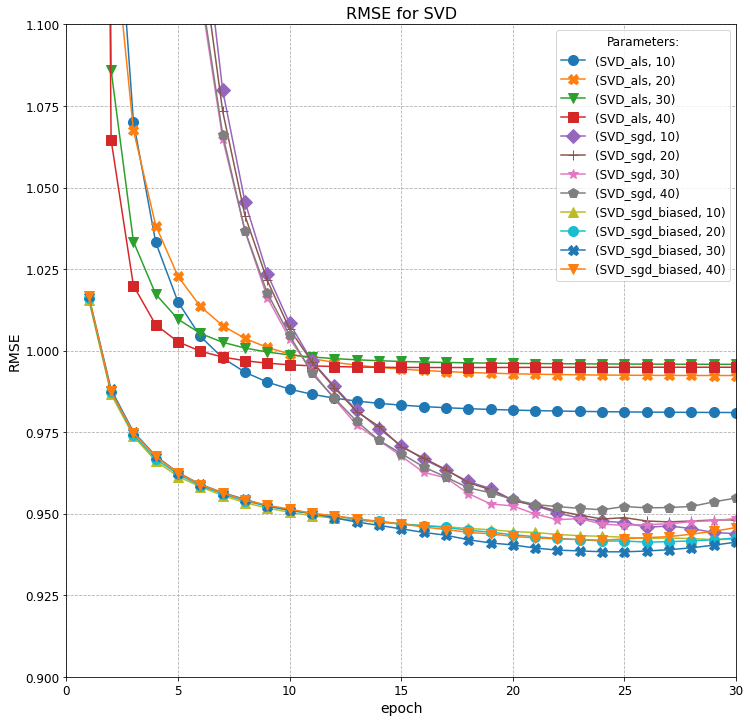

In [391]:
groups = df2.groupby(['algo', 'n_factors'])
fig, ax = plt.subplots(figsize=(12, 12), nrows=1, ncols=1)
markers = ['o', 'X', 'v', 's', 'D', '+', '*', 'p', '^']

for i, group in enumerate(groups):
    group_data = list(group[0])
    group_data[1] = str(group_data[1])
    line_label = '(' + ', '.join(group_data) + ')'
    group[1].plot(x='epoch', y='rmse_val', label=line_label, ax=ax,
                  marker=markers[i % len(markers)], markersize=10)
    
ax.set_title('RMSE for SVD', fontsize=16)
ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.legend(fontsize=14)
ax.grid(linestyle="--")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim(0, n_epochs)
ax.set_ylim(0.9, 1.1)
ax.legend(title='Parameters:', title_fontsize=12, fontsize=12, loc="upper right");

Лучший вариант:

In [394]:
df2.iloc[df2['rmse_val'].idxmin()]

epoch                             25
rmse_train                  0.772781
mae_train                   0.611832
rmse_val                    0.938304
mae_val                     0.738636
epoch_time_elapsed          3.599206
eval_time_elapsed           1.127064
algo                  SVD_sgd_biased
n_factors                         30
Name: 204, dtype: object

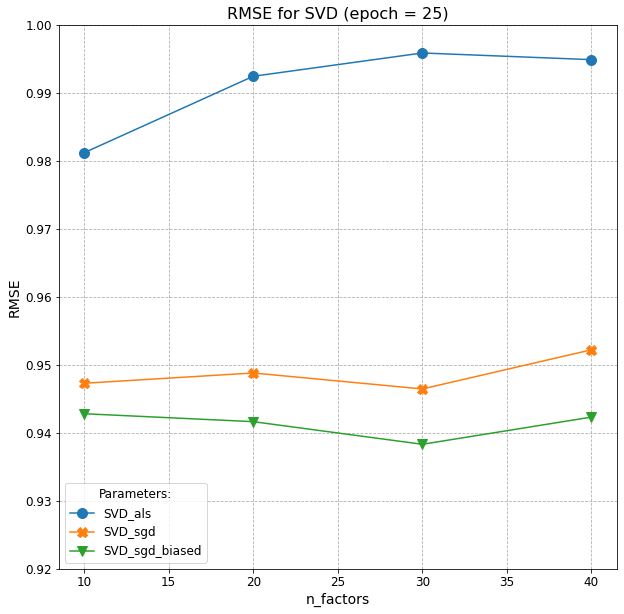

In [403]:
groups = df2[df2['epoch'] == 25].groupby('algo')
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
markers = ['o', 'X', 'v', 's', 'D', '+', '*', 'p', '^']

for i, group in enumerate(groups):
    line_label = group[0]
    group[1].plot(x='n_factors', y='rmse_val', label=line_label, ax=ax,
                  marker=markers[i % len(markers)], markersize=10)
    
ax.set_title('RMSE for SVD (epoch = 25)', fontsize=16)
ax.set_xlabel('n_factors', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.legend(fontsize=14)
ax.grid(linestyle="--")
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_xlim(0, n_epochs)
ax.set_ylim(0.92, 1.0)
ax.legend(title='Parameters:', title_fontsize=12, fontsize=12, loc="lower left");

Сравнение качества:

- наилучшее качество получено для `SVD_sgd_biased` на 25-ой эпохе при `n_factors=30`
- для исследуемого набора значений `n_factors` наблюдается небольшая немонотонная зависимость качества от значения данного параметра, причем зависимость разнонаправленная для `sgd` и `als`
- качество `SVD_als` ощутимо ниже качества `SVD_sgd` и `SVD_sgd_biased` (rmse больше)
- качество `SVD_sgd_biased` немного выше качества `SVD_sgd` (rmse меньше)

Сравнение скорости работы (по эпохам):

- `SVD_sgd` на ранних эпохах сходится медленнее `SVD_als` и `SVD_sgd_biased`, но максимальное качество достигается практически синхронно с `SVD_sgd_biased`
- `SVD_als` сходится быстрее других, сходимость монотонная
- `SVD_sgd` и `SVD_sgd_biased` сходятся немонотонно

In [408]:
df2['train_time'] = df2.groupby(['algo', 'n_factors'])[['epoch_time_elapsed']].cumsum()

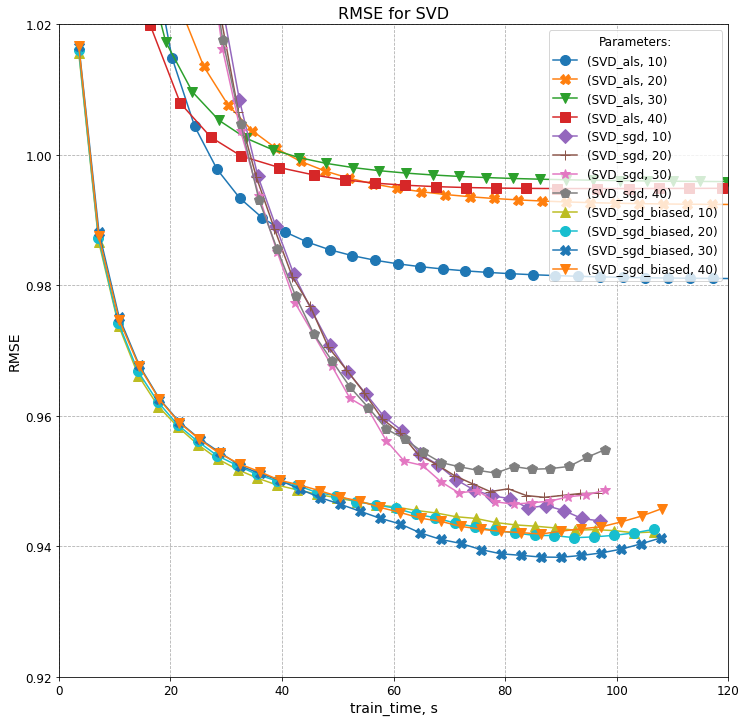

In [414]:
groups = df2.groupby(['algo', 'n_factors'])
fig, ax = plt.subplots(figsize=(12, 12), nrows=1, ncols=1)
markers = ['o', 'X', 'v', 's', 'D', '+', '*', 'p', '^']

for i, group in enumerate(groups):
    group_data = list(group[0])
    group_data[1] = str(group_data[1])
    line_label = '(' + ', '.join(group_data) + ')'
    group[1].plot(x='train_time', y='rmse_val', label=line_label, ax=ax,
                  marker=markers[i % len(markers)], markersize=10)
    
ax.set_title('RMSE for SVD', fontsize=16)
ax.set_xlabel('train_time, s', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.legend(fontsize=14)
ax.grid(linestyle="--")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim(0, 120)
ax.set_ylim(0.92, 1.02)
ax.legend(title='Parameters:', title_fontsize=12, fontsize=12, loc="upper right");

In [415]:
df2.iloc[df2['rmse_val'].idxmin()]

epoch                             25
rmse_train                  0.772781
mae_train                   0.611832
rmse_val                    0.938304
mae_val                     0.738636
epoch_time_elapsed          3.599206
eval_time_elapsed           1.127064
algo                  SVD_sgd_biased
n_factors                         30
train_time                  90.00215
Name: 204, dtype: object

Сравнение скорости работы (по времени):

- `SVD_als` имеет наибольшее время эпохи
- `SVD_sgd` имеет наименьшее время эпохи
- время получения наилучшего результата на `SVD_sgd_biased` - примерно 90 секунд
- сходимость по времени у `SVD_sgd` и `SVD_sgd_biased` примерно одинаковая, `SVD_als` сходится немного дольше

### Выводы

Сравним лучший вариант KNN с лучшим вариантом SVD:

In [418]:
df.iloc[df['rmse'].idxmin()]

algo           KNNWithMeans
user_based                0
similarity          pearson
k_neighbors              30
train_time        17.027974
test_time          7.027402
rmse               0.916424
mae                0.716432
total_time        24.055376
Name: 96, dtype: object

In [419]:
df2.iloc[df2['rmse_val'].idxmin()]

epoch                             25
rmse_train                  0.772781
mae_train                   0.611832
rmse_val                    0.938304
mae_val                     0.738636
epoch_time_elapsed          3.599206
eval_time_elapsed           1.127064
algo                  SVD_sgd_biased
n_factors                         30
train_time                  90.00215
Name: 204, dtype: object

| Характеристика | KNNWithMeans | SVD_sgd_biased |
| :- | -: | -: |
| Время обучения, с | 17 | 90
| Время предикта, с |  7 | 1
| RMSE | 0.916 | 0.938
| MAE | 0.716 | 0.738

Таким образом, в данной реализации `KNNWithMeans` оказался лучше `SVD` как по суммарному времени работы, так и по качеству. Для более эффективной реализации `SVD` на Python требуются дополнительные усилия (например, ускорение с помощью Cython). Кроме того, более тонкая настройка параметров `lr` (learning rate) и `reg` (коэффициент регуляризации) может дать прирост в качестве `SVD` (но перебор параметров удобнее делать после оптимизации по времени работы).